<a href="https://colab.research.google.com/github/zardemostoles/zardemostoles-uoc.edu/blob/master/TFG_EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Carga de módulos que se emplean en el notebook

In [1]:
# Se cargan las bibliotecas que se van a usar en el ejercicio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import sys

# Se monta el Google Drive
from google.colab import drive
drive.mount('/content/drive')
sys.path.append('/content/drive/MyDrive/TFG/')
from TFG_Comun import TFG_METADATA_ORIGINAL, TFG_METADATA_ITA, TFG_METADATA 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Ficheros que se cargan para el Análisis Exploratorio de Datos

In [2]:
# Fichero de metadatos:
print ("Primeros registros del fichero de metadatos:")
!cat {TFG_METADATA_ORIGINAL} | head

Primeros registros del fichero de metadatos:
image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767
ISIC_0000006,-1,female,25.0,posterior torso,NV,benign,0,0,1022,767
ISIC_0000007,-1,female,25.0,posterior torso,NV,benign,0,16,1022,767
ISIC_0000008,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
ISIC_0000009,-1,female,30.0,anterior torso,NV,benign,0,8,1022,767


In [3]:
# Fichero de tipo de tono de piel ITA:
print ("Primeros registros del fichero de tipo de tono de piel ITA:")
!cat {TFG_METADATA_ITA} | head

Primeros registros del fichero de tipo de tono de piel ITA:
image_name,tipo_ITA
ISIC_0000002,6
ISIC_0053467,1
ISIC_0053459,1
ISIC_0000000,6
ISIC_0053470,6
ISIC_0053515,1
ISIC_0053456,1
ISIC_0053506,1
ISIC_0053475,1


## Carga y preparación del dataframe Pandas

In [4]:
# Se crea el dataframe pandas con los metadatos 
# y se muestran las 5 primeras filas               
df_ISIC = pd.read_csv(TFG_METADATA_ORIGINAL)
df_ISIC.head(5)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target,tfrecord,width,height
0,ISIC_0000000,-1,female,55.0,anterior torso,NV,benign,0,4,1022,767
1,ISIC_0000001,-1,female,30.0,anterior torso,NV,benign,0,18,1022,767
2,ISIC_0000002,-1,female,60.0,upper extremity,MEL,malignant,1,0,1022,767
3,ISIC_0000003,-1,male,30.0,upper extremity,NV,benign,0,24,1022,767
4,ISIC_0000004,-1,male,80.0,posterior torso,MEL,malignant,1,14,1022,767


In [5]:
# Se comprueba que no hay información de ID de paciente
df_ISIC["patient_id"].unique()

array([-1])

In [6]:
# Dimensiones del dataframe con los metadatos
df_ISIC.shape

(25331, 11)

In [7]:
# Se crea el dataframe pandas con los tipos de tono de piel ITA 
# y se muestran las 5 primeras filas               
df_ITA = pd.read_csv(TFG_METADATA_ITA)
df_ITA.head(5)

,image_name,tipo_ITA
0,ISIC_0000002,6
1,ISIC_0053467,1
2,ISIC_0053459,1
3,ISIC_0000000,6
4,ISIC_0053470,6


In [8]:
# Dimensiones del dataframe con los tipos de tono de piel ITA 
df_ITA.shape

(23218, 2)

In [9]:
# Se elimina la columna de ID de paciente
# y otras columnas no necesarias
df_ISIC = df_ISIC.drop(columns=["patient_id", "tfrecord", "width", "height"], axis=1)

In [10]:
# Se cuentan cuantas imágenes son "downsampled"
df_ISIC[df_ISIC['image_name'].str.contains("_downsampled")]['image_name'].count()

2074

In [11]:
# Se eliminan los registros con imágenes "downsampled"
df_ISIC = df_ISIC[df_ISIC['image_name'].str.contains("_downsampled")==False]

In [12]:
# Se combinan los dataframes de metadatos y tipos de tono de piel
df_ISIC = df_ISIC.merge(df_ITA, on='image_name', how='left')

In [13]:
# Dimensiones del dataframe con datos combinados
df_ISIC.shape

(23257, 8)

In [14]:
# Se convierte el tipo de tono de piel a cadena
df_ISIC["tipo_ITA"] = df_ISIC["tipo_ITA"].fillna("-1").astype(int).astype(str).replace('-1', None)
# Se crean agrupamientos de edades
bins = [0, 15, 30, 45, 60, 75, 90, 120]
# Se crea una nueva columna con agrupaciones por edades
df_ISIC['age_group_approx'] = pd.cut(df_ISIC['age_approx'], bins).astype(str).replace('nan', 'unknown')
df_ISIC.dtypes

image_name                        object
sex                               object
age_approx                       float64
anatom_site_general_challenge     object
diagnosis                         object
benign_malignant                  object
target                             int64
tipo_ITA                          object
age_group_approx                  object
dtype: object

## Análisis exploratorio de datos

In [15]:
# Se transforma el valor binario del diagnóstico a texto
df_ISIC['target'] = df_ISIC['target'].replace({0: "no melanoma", 1: "melanoma"})

In [16]:
print("Total de casos\n")
print("Totales")
print((df_ISIC['target'].value_counts()).to_string())
print("\nPorcentajes")
print(round(df_ISIC['target'].value_counts(normalize=True) * 100,2).to_string())

Total de casos

Totales
no melanoma    19109
melanoma        4148

Porcentajes
no melanoma    82.16
melanoma       17.84


In [17]:
# Desglose por variables categóricas
col_categories = ["sex", "age_group_approx", "tipo_ITA", "anatom_site_general_challenge"]
for col in col_categories:
  print(col)
  print("===============================")
  print("Total de casos\n")
  print("Totales")
  print((df_ISIC[col].value_counts()).to_string())
  print("\nPorcentajes")
  print(round(df_ISIC[col].value_counts(normalize=True) * 100,2).to_string())
  print("Totales")
  print(pd.crosstab(df_ISIC[col],df_ISIC["target"]))
  print("\nPorcentajes")
  crosstb = round(pd.crosstab(df_ISIC[col],df_ISIC["target"], normalize='index')*100, 2)
  print(crosstb)
  print("\n")

sex
Total de casos

Totales
male       12279
female     10774
unknown      204

Porcentajes
male       52.80
female     46.33
unknown     0.88
Totales
target   melanoma  no melanoma
sex                           
female       1867         8907
male         2247        10032
unknown        34          170

Porcentajes
target   melanoma  no melanoma
sex                           
female      17.33        82.67
male        18.30        81.70
unknown     16.67        83.33


age_group_approx
Total de casos

Totales
(45, 60]    6230
(30, 45]    6086
(60, 75]    5544
(75, 90]    2619
(15, 30]    2078
(0, 15]      423
unknown      277

Porcentajes
(45, 60]    26.79
(30, 45]    26.17
(60, 75]    23.84
(75, 90]    11.26
(15, 30]     8.93
(0, 15]      1.82
unknown      1.19
Totales
target            melanoma  no melanoma
age_group_approx                       
(0, 15]                  7          416
(15, 30]               154         1924
(30, 45]               775         5311
(45, 60]         

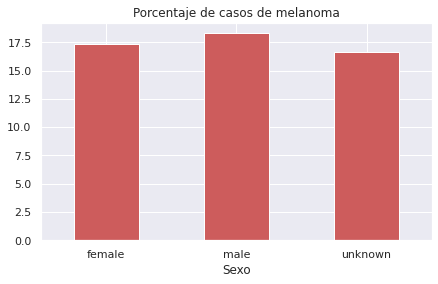

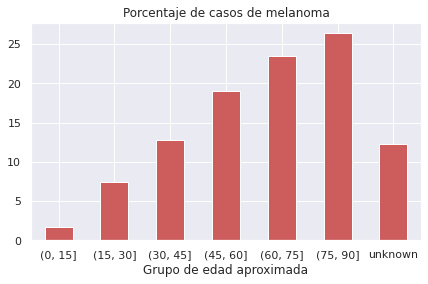

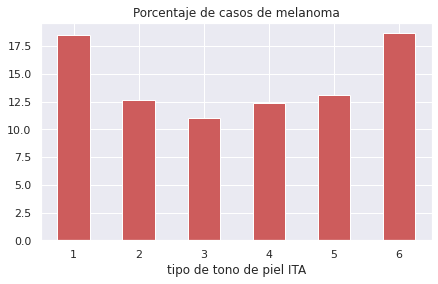

In [18]:
# Representación gráfica
col_bars = {
    "sex": "Sexo",
    "age_group_approx": "Grupo de edad aproximada",
    "tipo_ITA": "tipo de tono de piel ITA"
}
for key, value in col_bars.items():
  crosstb = round(pd.crosstab(df_ISIC[key],df_ISIC["target"], normalize='index')*100, 2)
  ax = crosstb['melanoma'].plot(title="Porcentaje de casos de melanoma", kind="bar", color="indianred",
                  stacked=False, rot=0, figsize=(7,4))
  ax.set_xlabel(value);
  plt.show();


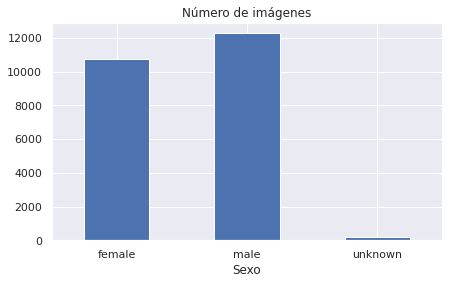

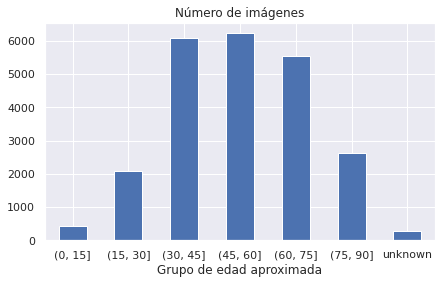

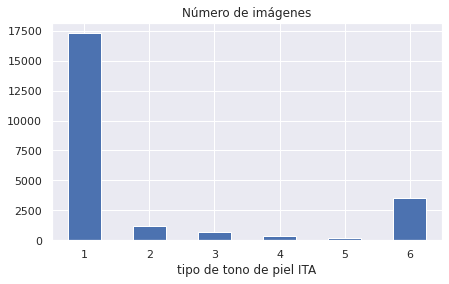

In [19]:
col_bars = {
    "sex": "Sexo",
    "age_group_approx": "Grupo de edad aproximada",
    "tipo_ITA": "tipo de tono de piel ITA"
}

for key, value in col_bars.items():
  ax = df_ISIC[key]\
                             .value_counts().sort_index()\
                             .plot(kind='bar',rot=0,
                             figsize=(7,4));
  ax.set_xlabel(value);
  ax.set_title("Número de imágenes");
  plt.show();

In [20]:
# Se transforma el valor de diagnóstico de texto a binario
df_ISIC['target'] = df_ISIC['target'].replace({"no melanoma": 0, "melanoma": 1})
# Guarda el dataframe en un fichero CSV
!mv {TFG_METADATA} {TFG_METADATA}.back
df_ISIC.to_csv(TFG_METADATA,index=False)